## Init

In [1]:
## Check core SDK version number
import azureml.core
import mlflow
import os

from azureml.core import (Datastore, Dataset, Environment, Experiment, ScriptRunConfig,
                          Workspace)
from azureml.core.authentication import InteractiveLoginAuthentication
from IPython.display import display



print("[INFO] SDK version:", azureml.core.VERSION)

## due to diferent tenant -> typically customer tenant
# interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")

ws = Workspace.from_config()
print("[SUCCESS] LOGGED IN: ",ws.name, ws.resource_group, ws.location, ws.subscription_id, sep=' @ ')

## set mlflow backend to AML
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

print("[INFO] MLFlow wired to AML:", "experiments.azureml.net" in mlflow.get_tracking_uri())

[INFO] SDK version: 1.17.0
[SUCCESS] LOGGED IN:  @ mlops-demo @ mlops-rg @ westeurope @ 6ee947fa-0d77-4915-bf68-4a83a8bec2a4
[INFO] MLFlow wired to AML: True


## Config

In [2]:
aml_compute = "aml-cluster"
aml_ds = "aml_data"# "mmaadlsgen2_test"
# aml_dset = 'noa_weather'
aml_dset = "oj_sample_data"
aml_experiment = "mlflow-azureml"
loc_data = "data/demo_data"

In [3]:
## List all datastores registered in the current workspace
datastores = ws.datastores
for name, datastore in datastores.items():
    print(f"{name} ({datastore.datastore_type})")



mmaadlsgen2_test (AzureDataLakeGen2)
modeldata (AzureBlob)
dbxstorage_delta (AzureBlob)
aml_data (AzureBlob)
azureml_globaldatasets (AzureBlob)
covidhack_file (AzureFile)
covidhack_blob (AzureBlob)
covidhack (AzureFile)
workspacefilestore (AzureFile)
workspaceblobstore (AzureBlob)


In [4]:
## set the datastore
ds = ws.datastores[aml_ds]
print(f"[INFO] Datastore: {ds.name}, type: {ds.datastore_type}")

[INFO] Datastore: aml_data, type: AzureBlob


##  EDA

In [5]:
# wtds = Dataset.get_by_name(ws, name=aml_dset)
wtds = Dataset.get_by_name(ws, name='noa_weather')
pdf = wtds.to_pandas_dataframe()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 24 columns):
index                      600 non-null int64
usaf                       600 non-null object
wban                       600 non-null int64
datetime                   600 non-null datetime64[ns]
latitude                   600 non-null float64
longitude                  600 non-null float64
elevation                  600 non-null float64
windAngle                  282 non-null float64
windSpeed                  309 non-null float64
temperature                594 non-null float64
seaLvlPressure             85 non-null float64
cloudCoverage              84 non-null object
presentWeatherIndicator    52 non-null float64
pastWeatherIndicator       12 non-null float64
precipTime                 93 non-null float64
precipDepth                93 non-null float64
snowDepth                  4 non-null float64
stationName                600 non-null object
countryOrRegion            600 non-null

https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python

In [6]:
# !pip install seaborn

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [8]:
df = pdf.copy()

In [9]:
# eda_target = "Revenue"
eda_target = "temperature"
categorical_features_list = ['usaf', 'wban','stationName', 'countryOrRegion', 'p_k',
       'year', 'day', 'version', 'month', eda_target]
quantitative_features_list = ['latitude', 'longitude', 'elevation',
       'windAngle', 'windSpeed', eda_target]


In [10]:
cols_to_drop = ["index"] # or empty
cols_at_end = [eda_target]

Let's just remove [] and the features with 30% or less NaN values

In [11]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]

for c in cols_to_drop:
    del df2[c]
    
# del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')

df2 = df2[[c for c in df2 if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df2]]

df = df2

List of dropped columns: index, seaLvlPressure, cloudCoverage, presentWeatherIndicator, pastWeatherIndicator, precipTime, precipDepth, snowDepth, 



In [12]:
df.columns

Index(['usaf', 'wban', 'datetime', 'latitude', 'longitude', 'elevation',
       'windAngle', 'windSpeed', 'stationName', 'countryOrRegion', 'p_k',
       'year', 'day', 'version', 'month', 'temperature'],
      dtype='object')

count    594.000000
mean      -0.204040
std       13.585298
min      -28.900000
25%      -10.700000
50%       -3.000000
75%        7.700000
max       36.000000
Name: temperature, dtype: float64


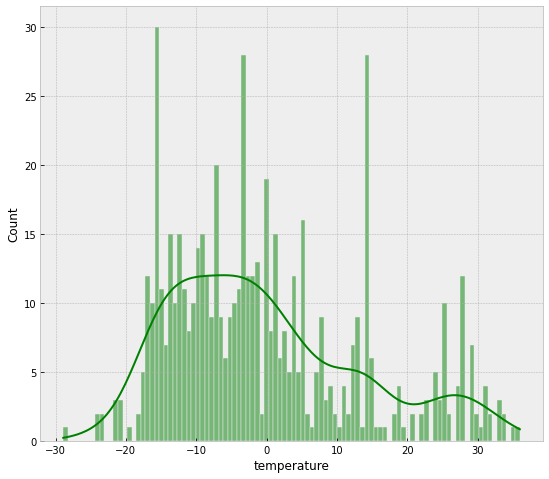

In [13]:
print(df[eda_target].describe())
plt.figure(figsize=(9, 8))
sns.histplot(df[eda_target], color='g', bins=100, kde=True);

#### Numerical data distribution

In [14]:
list(set(df.dtypes.tolist()))

[dtype('<M8[ns]'), dtype('float64'), dtype('int64'), dtype('O')]

In [15]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,wban,latitude,longitude,elevation,windAngle,windSpeed,year,day,version,month,temperature
0,99999,61.045,28.144,106.0,180.0,3.1,2018,3,1.0,1,1.0
1,94740,44.385,-74.207,507.0,0.0,0.0,2018,2,1.0,1,-28.9
2,94074,40.807,-104.755,1643.0,NaN,NaN,2018,1,1.0,1,-12.4
3,3067,38.870,-100.963,875.0,NaN,NaN,2018,3,1.0,1,-10.4
4,94077,42.425,-103.736,1343.0,NaN,NaN,2018,2,1.0,1,-3.8


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/anaconda/envs/azureml_py3

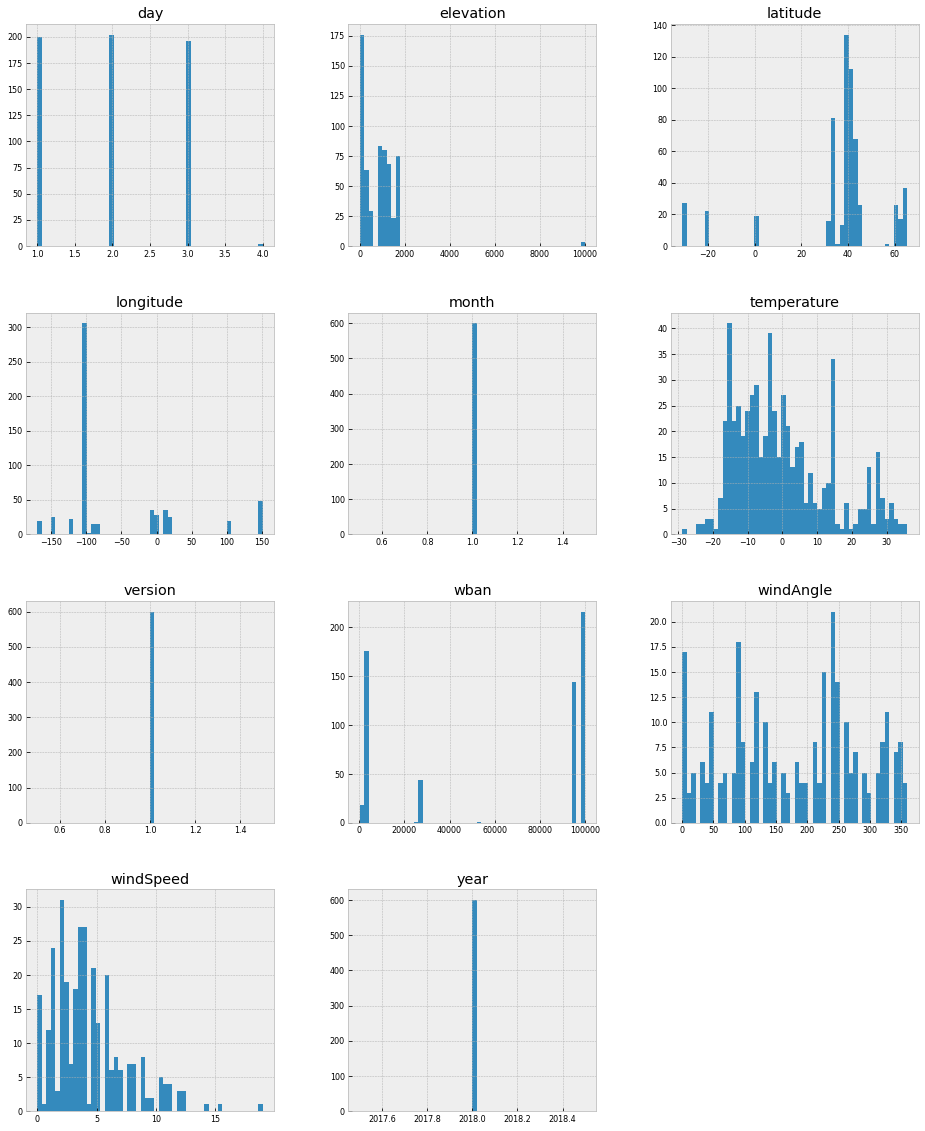

In [16]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

#### Correlation

In [17]:
df_num_corr = df_num.corr()[eda_target][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Target {}:\n{}".format(len(golden_features_list), eda_target,golden_features_list))

There is 3 strongly correlated values with Target temperature:
longitude    0.789370
elevation   -0.571166
latitude    -0.616294
Name: temperature, dtype: float64


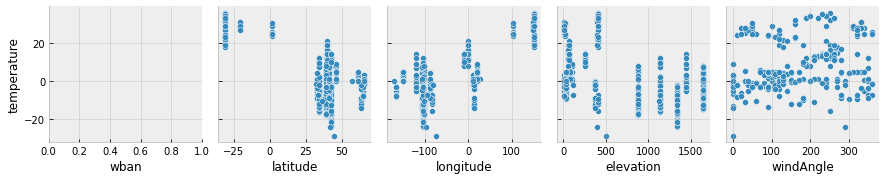

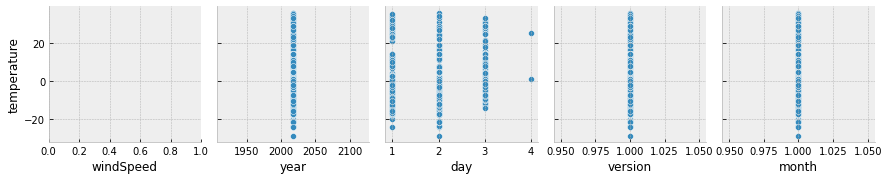

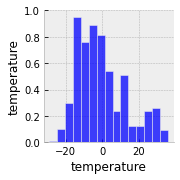

In [18]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=[eda_target])

In [19]:
golden_features_list

longitude    0.789370
elevation   -0.571166
latitude    -0.616294
Name: temperature, dtype: float64

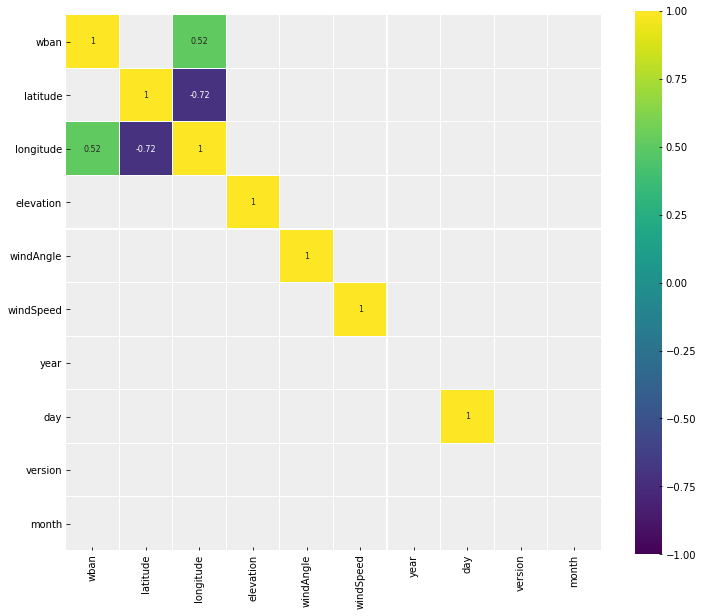

In [20]:
corr = df_num.drop(eda_target, axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### Q -> Q (Quantitative to Quantitative relationship)

In [21]:

df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

,latitude,longitude,elevation,windAngle,windSpeed,temperature
0,61.045,28.144,106.0,180.0,3.1,1.0
1,44.385,-74.207,507.0,0.0,0.0,-28.9
2,40.807,-104.755,1643.0,NaN,NaN,-12.4
3,38.870,-100.963,875.0,NaN,NaN,-10.4
4,42.425,-103.736,1343.0,NaN,NaN,-3.8


In [22]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse.append(eda_target)
features_to_analyse

['latitude', 'longitude', 'elevation', 'temperature']

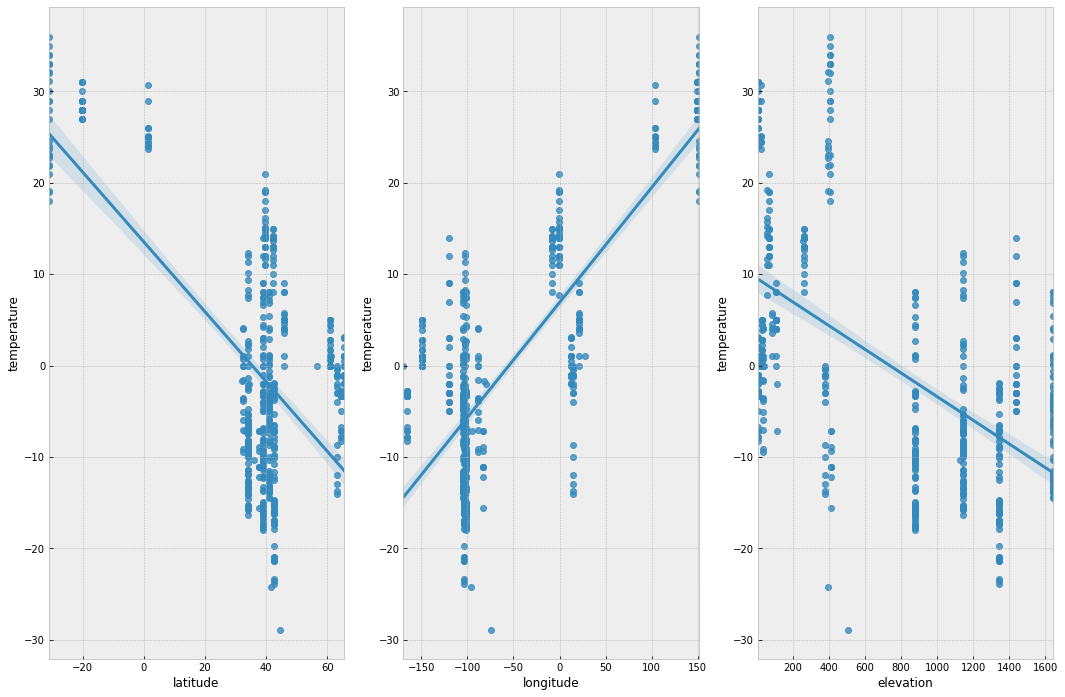

In [23]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y=eda_target, data=df[features_to_analyse], ax=ax)

#### C -> Q (Categorical to Quantitative relationship)

In [24]:
# quantitative_features_list[:-1] as the last column is SalePrice and we want to keep it
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.head()

,usaf,wban,datetime,stationName,countryOrRegion,p_k,year,day,version,month,temperature
0,029580,99999,2018-01-03 05:20:00,LAPPEENRANTA,FI,029580-99999,2018,3,1.0,1,1.0
1,726228,94740,2018-01-02 11:51:00,ADIRONDACK REGIONAL ARPT,US,726228-94740,2018,2,1.0,1,-28.9
2,999999,94074,2018-01-01 03:55:00,NUNN 7 NNE,US,999999-94074,2018,1,1.0,1,-12.4
3,999999,3067,2018-01-03 12:55:00,OAKLEY 19 SSW,US,999999-03067,2018,3,1.0,1,-10.4
4,999999,94077,2018-01-02 19:50:00,HARRISON 20 SSE,US,999999-94077,2018,2,1.0,1,-3.8


In [25]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 4 non numerical features including:
['usaf', 'stationName', 'countryOrRegion', 'p_k']


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

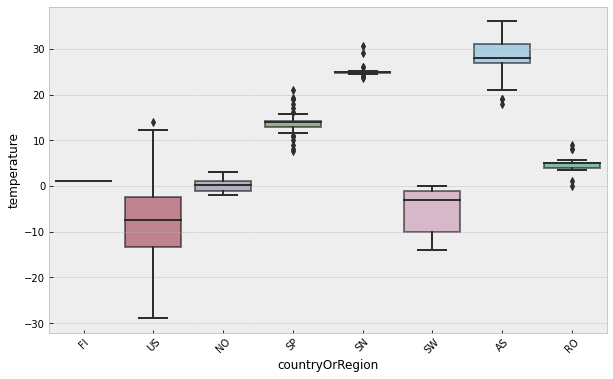

In [26]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='countryOrRegion', y=eda_target, data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [27]:
features_to_analyse = categorical_features_list
# features_to_analyse.append(eda_target)

In [28]:
df_categ[features_to_analyse]

,usaf,wban,stationName,countryOrRegion,p_k,year,day,version,month,temperature
0,029580,99999,LAPPEENRANTA,FI,029580-99999,2018,3,1.0,1,1.0
1,726228,94740,ADIRONDACK REGIONAL ARPT,US,726228-94740,2018,2,1.0,1,-28.9
2,999999,94074,NUNN 7 NNE,US,999999-94074,2018,1,1.0,1,-12.4
3,999999,3067,OAKLEY 19 SSW,US,999999-03067,2018,3,1.0,1,-10.4
4,999999,94077,HARRISON 20 SSE,US,999999-94077,2018,2,1.0,1,-3.8
...,...,...,...,...,...,...,...,...,...,...
595,703835,25628,ST. GEORGE AIRPORT,US,703835-25628,2018,2,1.0,1,0.0
596,999999,3054,MULESHOE 19 S,US,999999-03054,2018,2,1.0,1,-11.9
597,999999,3067,OAKLEY 19 SSW,US,999999-03067,2018,3,1.0,1,8.1
598,720633,219,HARTSVILLE REGIONAL AIRPORT,US,720633-00219,2018,1,1.0,1,-2.0


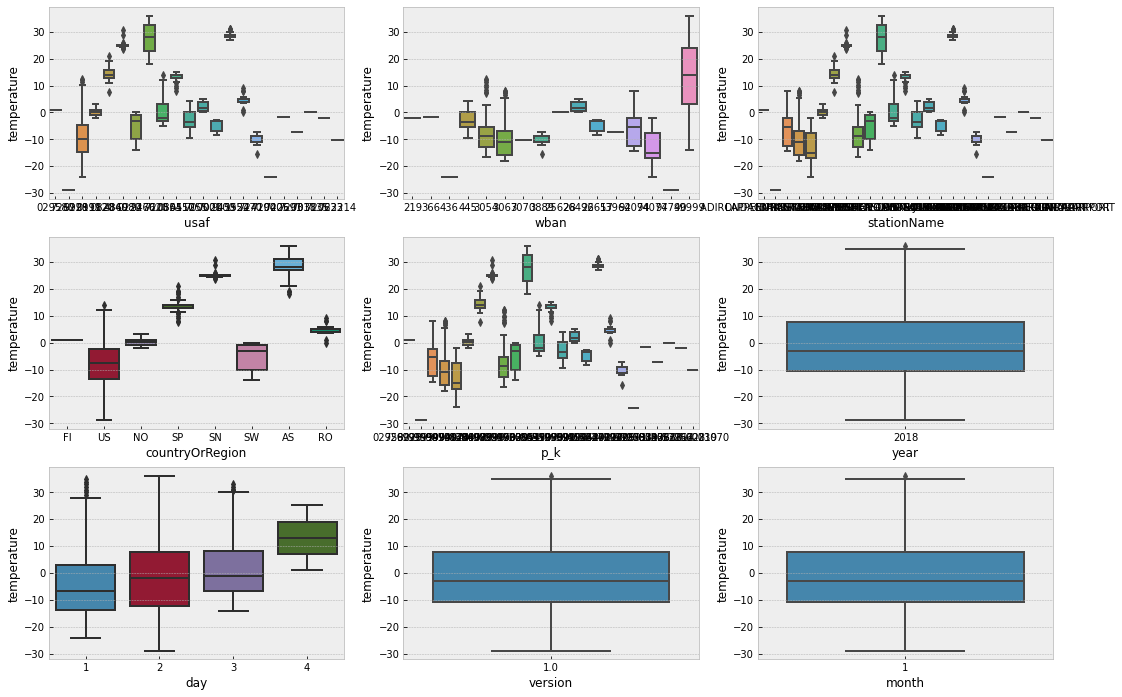

In [29]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.boxplot(x=features_to_analyse[i], y=eda_target, data=df_categ[features_to_analyse], ax=ax)

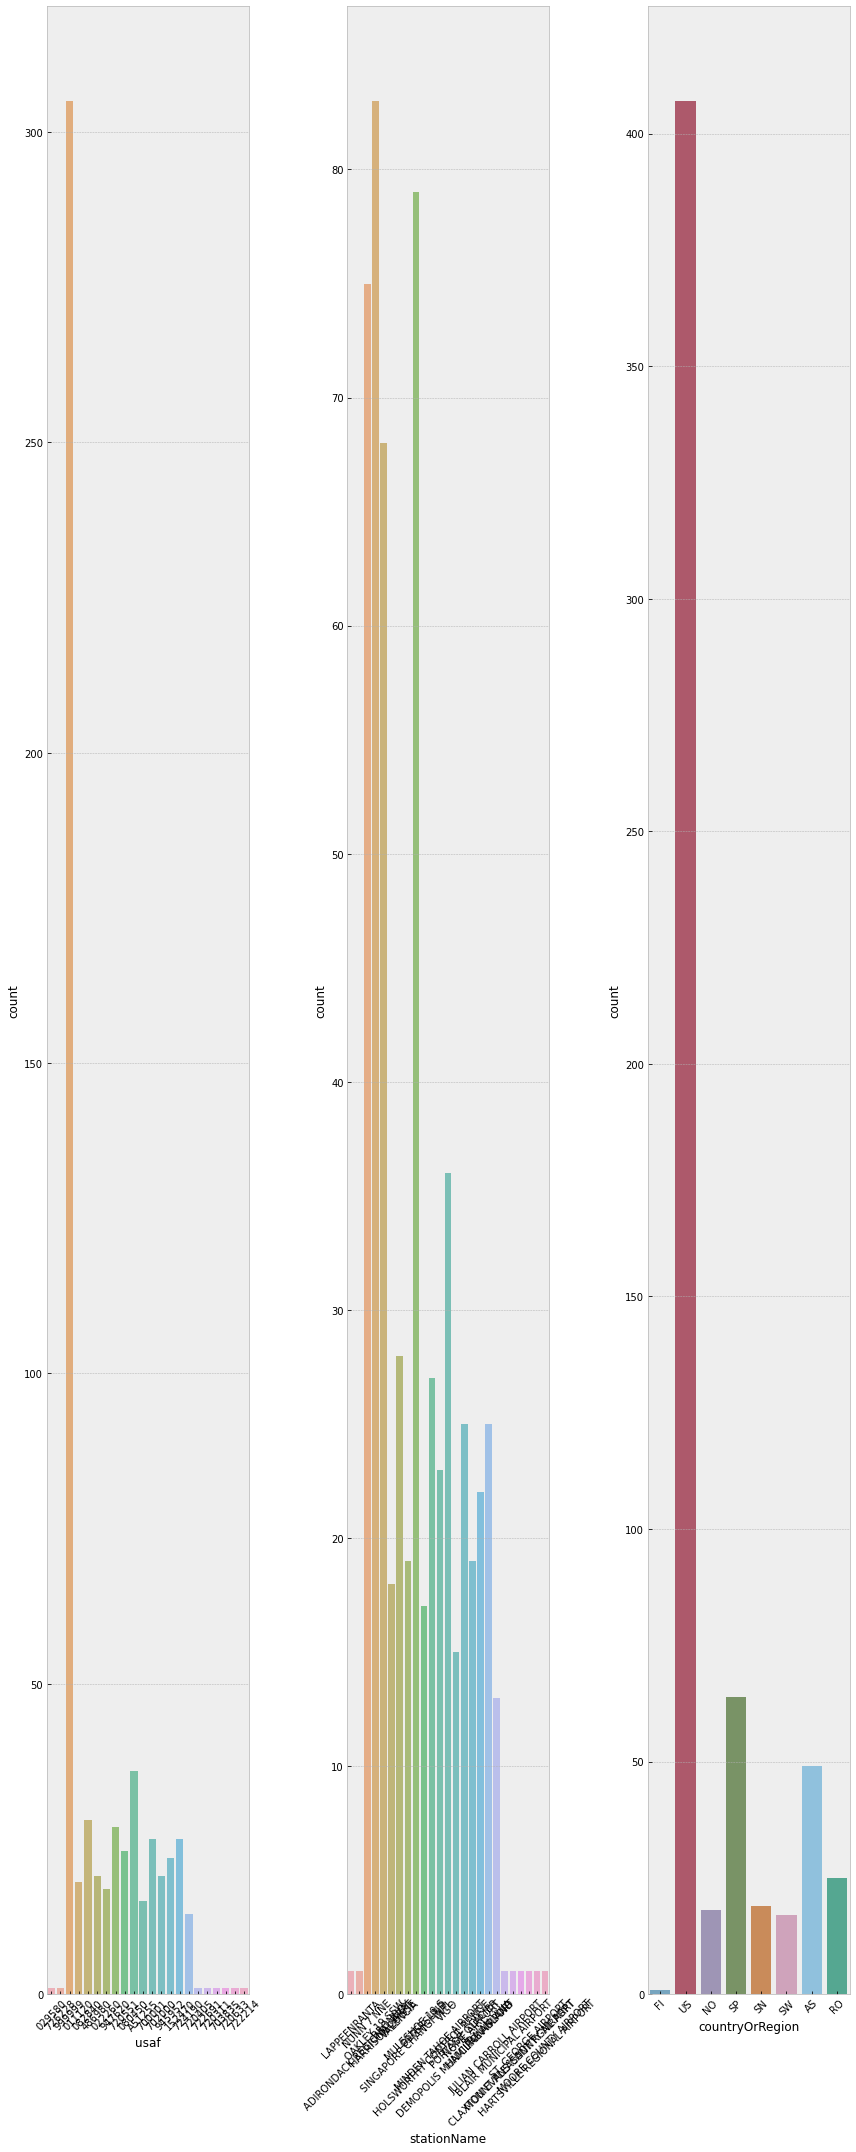

In [30]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

## Training

In [ ]:
mlflow.set_experiment(aml_experiment)
